In [2]:
import os
import sys
sys.path.append("..")
import torch
import subprocess
import traceback
import warnings
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np

from tqdm import tqdm
# n.pyimport hydra
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from src.metric import LWLRAP
from src.models import get_model
import src.configuration as C
import src.utils as utils
from src.metric import LWLRAP
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import MLFlowLogger

/opt/anaconda3/lib/python3.7/site-packages/pywt/_utils.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [3]:
config_str = """
globals:
  seed: 42
  device: cuda
  max_epochs: 30
  output_dir: output
  timestamp: None
  pretrained: False
  pretrained_model_dir: None
  only_pred: False
  folds:
    - 0
    - 1
    - 2
    - 3
    - 4
  debug: False
  kaggle: False

mlflow:
    experiment_name: rainforest
    tags:
      timestamp: None
      model_name: None
      loss_name: None
      hash_value: None
      message: baseline
data:
  root: ./
  use_train_data:
    - tp
    - fp
  train_tp_df_path: input/rfcx-species-audio-detection/train_tp.csv
  train_fp_df_path: input/rfcx-species-audio-detection/train_fp.csv
  train_audio_path: input/rfcx-species-audio-detection/train
  test_audio_path: input/rfcx-species-audio-detection/test
  sub_df_path: input/rfcx-species-audio-detection/sample_submission.csv


dataset:
  name: SpectrogramDataset
  height: 224
  width: 400
  period: 10
  shift_time: 10
  strong_label_prob: 1.0
  params:
    melspec:
      n_fft: 2048
      n_mels: 128
      fmin: 80
      fmax: 15000
      power: 2.0
    pcen:
      gain: 0.98
      bias: 2
      power: 0.5
      time_constant: 0.4
      eps: 0.000001

loss:
  name: LSEPStableLoss  # LSEPStableLoss LSEPLoss BCEWithLogitsLoss FocalLoss
  params:
    output_key: logit

optimizer:
  name: Adam
  params:
    lr: 0.001

scheduler:
  name: CosineAnnealingLR
  params:
    T_max: 10

split:
  name: StratifiedKFold  # MultilabelStratifiedKFold  StratifiedKFold
  params:
    n_splits: 5
    random_state: 42
    shuffle: True

model:
  name: EfficientNetSED
  output_key: logit
  params:
    base_model_name: efficientnet-b2
    pretrained: True
    num_classes: 24

loader:
  train:
    batch_size: 1
    shuffle: True
    num_workers: 10
  valid:
    batch_size: 1
    shuffle: False
    num_workers: 10
  test:
    batch_size: 1
    shuffle: False
    num_workers: 10

transforms:
  train:

  valid:

  test:

mixup:
  flag: False
  alpha: 0.2
  prob: 0.5

"""

In [4]:
import yaml
# config
config = yaml.safe_load(config_str)
device = "cuda"
# PSEUDO_THR = 0.3

# data
df, datadir = C.get_metadata(config)
all_recording_ids = df["recording_id"].values

In [5]:
import cv2
import random
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
import torch.utils.data as data
import warnings
from pathlib import Path

PSEUDO_LABEL_VALUE = 1.0
"""
valid/testではtime flagは使わない
60s分にaudioの長さを揃える
10s単位に分割してリスト化してimage変換
"""
class SpectrogramDataset(data.Dataset):
    def __init__(self,
                 df: pd.DataFrame,
                 phase: str,
                 datadir: Path,
                 height: int,
                 width: int,
                 period: int,
                 shift_time: int,
                 strong_label_prob: int, 
                 waveform_transforms=None,
                 spectrogram_transforms=None,
                 melspectrogram_parameters={},
                 pcen_parameters = {}):
        self.df = df
        self.phase = phase
        self.datadir = datadir
        self.height = height
        self.width = width
        self.period = period
        self.shift_time = shift_time
        self.strong_label_prob = strong_label_prob
        self.waveform_transforms = waveform_transforms
        self.spectrogram_transforms = spectrogram_transforms
        self.melspectrogram_parameters = melspectrogram_parameters
        self.pcen_parameters = pcen_parameters
        self.train_pseudo = pd.read_csv("./input/rfcx-species-audio-detection/train_toda60_thr5.csv")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        
        # train_pseudo = self.train_pseudo.sample(frac=0.5)  # 毎回50%sampling
        train_pseudo = self.train_pseudo
        
        sample = self.df.loc[idx, :]
        recording_id = sample["recording_id"]
        y, sr = sf.read(self.datadir / f"{recording_id}.flac")  # for default
        effective_length = sr * self.period
        total_time = 60  # 音声を全て60sに揃える
        y = adjust_audio_length(y, sr, total_time)
        if self.waveform_transforms:
            y = self.waveform_transforms(y)


        # PERIODO単位に分割(現在は6等分)
        split_y = split_audio(y, total_time, self.period, self.shift_time, sr)
        
        images = []
        # 分割した音声を一つずつ画像化してリストで返す
        for y in split_y:
            image = wave2image_normal(y, sr, self.width, self.height, self.melspectrogram_parameters)
            images.append(image)

        if self.phase == 'valid':
            query_string = f"recording_id == '{recording_id}'"
            all_events = self.df.query(query_string)
            labels = np.zeros(24, dtype=np.float32)
            for idx, row in all_events.iterrows():
                if row['data_type'] == 'tp':
                    labels[int(row['species_id'])] = 1.0
                else:
                    labels[int(row['species_id'])] = -1.0

            labels = add_pseudo_label(labels, recording_id, train_pseudo)  # pseudo label
            return np.asarray(images), labels

        elif self.phase == 'test':
            labels = -1  # testなので-1を返す
            return np.asarray(images), labels
        else:
            raise NotImplementedError



def adjust_audio_length(y, sr, total_time=60):
    try:
        assert len(y)==total_time * sr
    except:
        print('Assert Error')
        # データの長さを全てtotal_time分にする
        len_y = len(y)
        total_length = total_time * sr
        if len_y < total_length:
            new_y = np.zeros(total_length, dtype=y.dtype)
            start = np.random.randint(total_length - len_y)
            new_y[start:start + len_y] = y
            y = new_y.astype(np.float32)
        elif len_y > total_length:
            start = np.random.randint(len_y - total_length)
            y = y[start:start + total_length].astype(np.float32)
        else:
            y = y.astype(np.float32)
    return y

"""
############
wave → image 変換
############
"""
def wave2image_normal(y, sr, width, height, melspectrogram_parameters):
    """
    通常のmelspectrogram変換
    """
    melspec = librosa.feature.melspectrogram(y, sr=sr, **melspectrogram_parameters)
    melspec = librosa.power_to_db(melspec).astype(np.float32)

    image = mono_to_color(melspec)
    image = cv2.resize(image, (width, height))
    image = np.moveaxis(image, 2, 0)
    image = (image / 255.0).astype(np.float32)
    return image


def mono_to_color(X: np.ndarray,
                  mean=None,
                  std=None,
                  norm_max=None,
                  norm_min=None,
                  eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V


def split_audio(y, total_time, period, shift_time, sr):
    # PERIODO単位に分割(現在は6等分)
    # split_y = np.split(y, total_time/PERIOD)
    num_data = int(total_time / shift_time)
    shift_length = sr*shift_time
    effective_length = sr*period
    split_y = []
    for i in range(num_data):
        start = shift_length * i
        finish = start + effective_length
        split_y.append(y[start:finish])
    
    return split_y


def add_pseudo_label(labels, recording_id, pseudo_df, beginning_time=None, ending_time=None):
    
    try:
        query_string = f"recording_id == '{recording_id}'"
        if beginning_time == None and ending_time == None:
            pass
        else:
            query_string += f" & t_min < {ending_time} & t_max > {beginning_time}"

        # 同じrecording_idのものを
        all_tp_events = pseudo_df.query(query_string)
        pseudo_labels = (np.sum(all_tp_events.loc[:, "0":"23"].values, axis=0) > 0).astype('float32')
        pseudo_labels = np.where(pseudo_labels > 0, PSEUDO_LABEL_VALUE, pseudo_labels)  # label smoothing
    # pseudo_dfがNoneだったり該当のrecording_idのpseudo_labelがない場合はスキップされる    
    except:
        pseudo_labels = np.zeros(24)
    labels = np.sum([labels, pseudo_labels], axis=0)  # labelsとpseudo labelを合体
    labels = np.where(labels >= 1.0, 1.0, labels).astype('float32')  # 1以上のものは1にする 
    return labels

In [6]:
dataset_config = config["dataset"]
dataset = SpectrogramDataset(
    df,
    phase='valid',
    datadir=datadir,
    height=dataset_config["height"],
    width=dataset_config["width"],
    period=dataset_config['period'],
    shift_time=dataset_config['shift_time'],
    strong_label_prob=dataset_config['strong_label_prob'],
    waveform_transforms=None,
    spectrogram_transforms=None,
    melspectrogram_parameters=dataset_config["params"]['melspec'],
    pcen_parameters=dataset_config['params']['pcen'])

loader_config = config["loader"]['valid']
loader = data.DataLoader(dataset, **loader_config)

In [7]:
model = get_model(config)
model_name = "EfficientNetSED"
fold=0
output_dir = Path("output/0203_195731")
try:
    ckpt = torch.load(output_dir / f'{model_name}-{fold}-v0.ckpt')  # TODO foldごとのモデルを取得できるようにする
except:
    ckpt = torch.load(output_dir / f'{model_name}-{fold}.ckpt')  # TODO foldごとのモデルを取得できるようにする
model.load_state_dict(ckpt['state_dict'])
model.eval().to(device)


output_key = "logit"
pseudo_label_dict = {}
with torch.no_grad():
    # xは複数のlist
    count = 0
    for (x_list, y), recording_id in tqdm(zip(loader, all_recording_ids)):
        count += 1
        batch_size = x_list.shape[0]
        x = x_list.view(-1, x_list.shape[2], x_list.shape[3], x_list.shape[4])  # batch>1でも可
        x = x.to(device)
        output = model.model(x, None, False)
        output = output[output_key]
        output = output.view(batch_size, -1, 24)  # (1, 6, 24)
        old_pred = output.sigmoid().detach().cpu().numpy()[0].max(axis=0)  # 1batchを前提に0こ目だけ取得 
        target = y.cpu().numpy()[0]
        if count == 8:
            break

Loaded pretrained weights for efficientnet-b2
7it [00:00, 17.69it/s]


In [8]:
model = get_model(config)
model_name = "EfficientNetSED"
fold=0
# output_dir = Path("output/0123_181828")
output_dir = Path("backup/0206_232645")
try:
    ckpt = torch.load(output_dir / f'{model_name}-{fold}-v0.ckpt')  # TODO foldごとのモデルを取得できるようにする
except:
    ckpt = torch.load(output_dir / f'{model_name}-{fold}.ckpt')  # TODO foldごとのモデルを取得できるようにする
model.load_state_dict(ckpt['state_dict'])
model.eval().to(device)


output_key = "logit"
pseudo_label_dict = {}
with torch.no_grad():
    # xは複数のlist
    count = 0
    for (x_list, y), recording_id in tqdm(zip(loader, all_recording_ids)):
        count += 1
        batch_size = x_list.shape[0]
        x = x_list.view(-1, x_list.shape[2], x_list.shape[3], x_list.shape[4])  # batch>1でも可
        x = x.to(device)
        output = model.model(x, None, False)
        output = output[output_key]
        output = output.view(batch_size, -1, 24)  # (1, 6, 24)
        new_pred = output.sigmoid().detach().cpu().numpy()[0].max(axis=0)  # 1batchを前提に0こ目だけ取得 
        target = y.cpu().numpy()[0]
        if count == 8:
            break

Loaded pretrained weights for efficientnet-b2
7it [00:00, 19.18it/s]


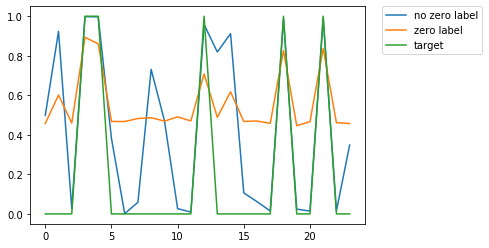

In [10]:
import matplotlib.pyplot as plt

plt.plot(old_pred, label="no zero label")
plt.plot(new_pred, label="zero label")
plt.plot(target, label="target")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()